In [1]:
!pip install yahoofinancials
!pip install ta

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [229]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.plotting import scatter_matrix
import math
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from yahoofinancials import YahooFinancials

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR, SVC, LinearSVC, LinearSVR
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
from keras import Sequential
from keras.layers import Dense, LSTM, Flatten
from pandas.tseries.offsets import BDay

from ta import *

%matplotlib inline

In [261]:
def getData(tickers,start,end):
    '''
    The function to download data from Yahoo Finance API. It takes a list of tickers, start date
    and end date, which is the last trading date. The return is a dataframe containing the
    tickers' adjusted close price and volume.

    Parameters:
        tickers: A list of tickers.
        start_date: The start date for fetching the data.
        end_date: The last date to fetch the data.
    Returns:
        df: Dataframe that contains the tickers' adjusted close price and volume.
    '''
    df = pd.DataFrame()
    if(len(tickers) > 0):
        for ticker in tickers:
            yahoo_financials = YahooFinancials(ticker)
            daily = yahoo_financials.get_historical_price_data(start, end, 'daily')
            if (ticker == 'CL=F'):
                print(daily)
            daily = daily.get(ticker).get('prices') 
            df_temp = pd.DataFrame.from_records(daily)
            df_temp = df_temp.drop(['close','date','high','low','open'],axis=1)
            df_temp = df_temp.rename(columns={'formatted_date':'date','adjclose':ticker, 'volume':ticker +'_volume' })
            df_temp['date'] = pd.to_datetime(df_temp['date'])
            df_temp.set_index('date', inplace=True)
            df = pd.concat([df,df_temp],axis=1)
    
    return df

In [262]:
tickers = ['GOOG' , 'SPY']
ticker_of_interest = 'GOOG'
start_date = datetime.datetime(2011,1,1).date()
end_date = datetime.datetime(2018,12,31).date()
today = datetime.datetime.now().date()
number_of_days_to_predict = 5
df = getData(tickers, start_date.strftime("%Y-%m-%d"), today.strftime("%Y-%m-%d"))

In [263]:
df.tail(20)

,GOOG,GOOG_volume,SPY,SPY_volume
date,,,,
2019-06-13,1088.770020,1057700,288.178375,48945200
2019-06-14,1085.349976,1111500,287.859955,52324700
2019-06-17,1092.500000,941600,287.969391,39205700
2019-06-18,1103.599976,1386700,290.984741,85434800
2019-06-19,1102.329956,1338800,291.641541,78674400
2019-06-20,1111.420044,1262000,294.427979,116570000
2019-06-21,1121.880005,1947600,294.000000,83309500
2019-06-24,1115.520020,1395600,293.640015,47582700
2019-06-25,1086.349976,1546900,290.760010,82028700


In [264]:
df.describe()

,GOOG,GOOG_volume,SPY,SPY_volume
count,2144.000000,2.144000e+03,2144.000000,2.144000e+03
mean,654.628785,3.047565e+06,186.052944,1.206443e+08
std,295.202970,2.476060e+06,56.111551,6.781477e+07
min,236.553345,7.900000e+03,93.996262,2.785650e+07
25%,390.039291,1.412800e+06,133.609451,7.565812e+07
50%,578.123047,2.143300e+06,186.055092,1.039102e+08
75%,919.787491,4.098900e+06,230.265575,1.464406e+08
max,1287.579956,2.819250e+07,299.309998,7.178287e+08


In [265]:
df.isna().sum()

GOOG           0
GOOG_volume    0
SPY            0
SPY_volume     0
dtype: int64

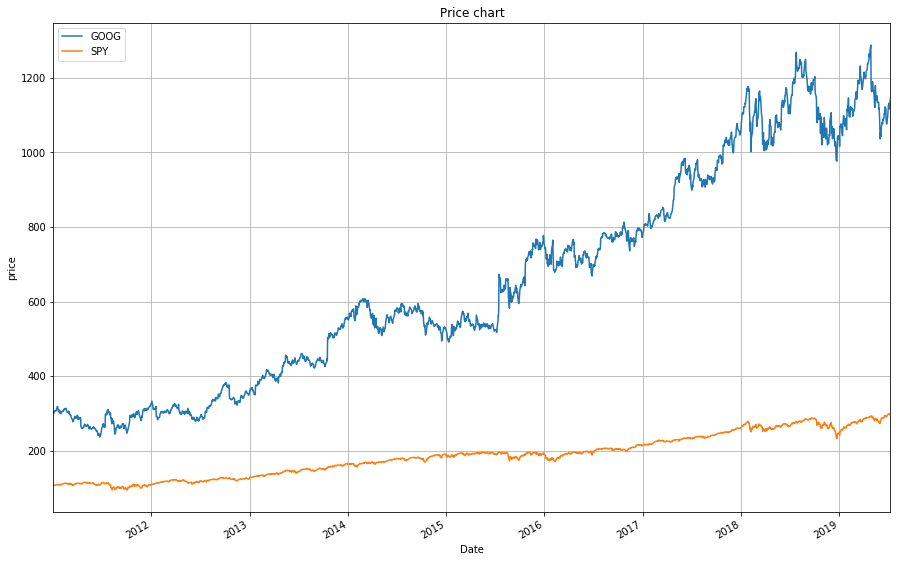

In [266]:
for ticker in tickers:
    ax = df[ticker].plot(title=ticker, figsize=(15,10), label=ticker)
    ax.legend()
    ax.grid()
    
plt.xlabel('Date')
plt.ylabel('price')
plt.title('Price chart')
plt.show()

In [273]:
def introduce_features(tickers, number_of_days_to_predict, df=df):
    '''
    The function to calculate different indecators and add it to the original
    dataframe. The indicatores are:
        *

    Parameters:
        df: Dataframe the contains the daily close price.
        ticker_of_interest: The ticker that will be predicted.
        tickers: A list of tickers.
        number_of_days_to_predict: number of days that wanted to be predicted
    Returns:
        df: Dataframe that contains the tickers' adjusted close price along
        with the calculated indecators and temporary future prices
    '''
    for ticker in tickers:
        print(ticker)
        #close_price = df[ticker] / df[ticker][0]
        close_price = df[ticker]
        df[ticker] = close_price
        daily_pct = close_price.pct_change(1)
        df[ticker + '_pct'] = daily_pct
        
        # Calculate the 5 days moving averages of the closing prices
        short_rolling = close_price.rolling(window=5).mean()
        df[ticker + '_short_rolling'] = short_rolling
        short_rolling_std = short_rolling.std()
        df[ticker + '_short_upper_band'] = df[ticker + '_short_rolling'] + (2 * short_rolling_std)
        df[ticker + '_short_lower_band'] = df[ticker + '_short_rolling'] - (2 * short_rolling_std)
        
        # Calculate the 10 and 100 days moving averages of the closing prices
        short_rolling = close_price.rolling(window=10).mean()
        df[ticker + '_short_rolling'] = short_rolling
        short_rolling_std = short_rolling.std()
        df[ticker + '_short_upper_band'] = df[ticker + '_short_rolling'] + (2 * short_rolling_std)
        df[ticker + '_short_lower_band'] = df[ticker + '_short_rolling'] - (2 * short_rolling_std)

        # 64 for three months working days. Or 100 as used by others
        long_rolling = close_price.rolling(window=100).mean()
        df[ticker + '_long_rolling'] = long_rolling
        long_rolling_std = long_rolling.std()
        df[ticker + '_long_upper_band'] = df[ticker + '_long_rolling'] + (2 * long_rolling_std)
        df[ticker + '_long_lower_band'] = df[ticker + '_long_rolling'] - (2 * long_rolling_std)
        
        df[ticker + '_rsi_5'] = momentum.rsi(df[ticker], n=5, fillna=False)
        df[ticker + '_rsi_10'] = momentum.rsi(df[ticker], n=10, fillna=False)
        df[ticker + '_rsi_64'] = momentum.rsi(df[ticker], n=100, fillna=False)
        
        df[ticker + '_force_index_5'] = volume.force_index(df[ticker], df[ticker + '_volume'], n=5, fillna=False)
        df[ticker + '_force_index_10'] = volume.force_index(df[ticker], df[ticker + '_volume'], n=10, fillna=False)
        df[ticker + '_force_index_64'] = volume.force_index(df[ticker], df[ticker + '_volume'], n=64, fillna=False)
        
        df[ticker + '_obv'] = volume.on_balance_volume(df[ticker], df[ticker + '_volume'], fillna=False)
        
        df[ticker + '_ema_5'] = trend.ema_indicator(df[ticker], n=5, fillna=False)
        df[ticker + '_ema_10'] = trend.ema_indicator(df[ticker], n=10, fillna=False)
        df[ticker + '_ema_64'] = trend.ema_indicator(df[ticker], n=100, fillna=False)
        
        df[ticker + '_trix_5'] = trend.trix(df[ticker], n=5, fillna=False)
        df[ticker + '_trix_10'] = trend.trix(df[ticker], n=10, fillna=False)
        df[ticker + '_trix_64'] = trend.trix(df[ticker], n=100, fillna=False)
        
        if(ticker != ticker_of_interest):
            pass
            
        else:
            # add the price and the future price of the symbol to the output data frame ans_df
            df[ticker + '_future_price'] = np.concatenate((close_price[number_of_days_to_predict:].values, [np.nan]*number_of_days_to_predict))
            
    df = df.fillna(method='backfill')
    df = df.fillna(method='pad')
        
    return df

In [276]:
more_features = introduce_features(tickers, number_of_days_to_predict, df)
more_features

GOOG
SPY


,GOOG,GOOG_volume,SPY,SPY_volume,GOOG_pct,GOOG_short_rolling,GOOG_short_upper_band,GOOG_short_lower_band,GOOG_long_rolling,GOOG_long_upper_band,...,SPY_force_index_5,SPY_force_index_10,SPY_force_index_64,SPY_obv,SPY_ema_5,SPY_ema_10,SPY_ema_64,SPY_trix_5,SPY_trix_10,SPY_trix_64
date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,301.046600,4748100,107.077354,138725200,-0.003690,305.526813,894.074985,-283.021360,289.218936,859.062854,...,9.631802e+05,-5.063533e+07,-1.023073e+08,-1.374097e+08,107.257938,107.926546,112.046371,0.044054,0.143003,0.026264
2011-01-04,299.935760,3662600,107.018349,137409700,-0.003690,305.526813,894.074985,-283.021360,289.218936,859.062854,...,9.631802e+05,-5.063533e+07,-1.023073e+08,-1.374097e+08,107.257938,107.926546,112.046371,0.044054,0.143003,0.026264
2011-01-05,303.397797,5083500,107.574608,133975300,0.011543,305.526813,894.074985,-283.021360,289.218936,859.062854,...,9.631802e+05,-5.063533e+07,-1.023073e+08,-3.434400e+06,107.257938,107.926546,112.046371,0.044054,0.143003,0.026264
2011-01-06,305.604523,4131000,107.363914,122519000,0.007273,305.526813,894.074985,-283.021360,289.218936,859.062854,...,9.631802e+05,-5.063533e+07,-1.023073e+08,-1.259534e+08,107.257938,107.926546,112.046371,0.044054,0.143003,0.026264
2011-01-07,307.069031,4218100,107.153206,156034600,0.004792,305.526813,894.074985,-283.021360,289.218936,859.062854,...,9.631802e+05,-5.063533e+07,-1.023073e+08,-2.819880e+08,107.257938,107.926546,112.046371,0.044054,0.143003,0.026264
2011-01-10,305.958191,3170100,107.018349,122401700,-0.003618,305.526813,894.074985,-283.021360,289.218936,859.062854,...,9.631802e+05,-5.063533e+07,-1.023073e+08,-4.043897e+08,107.170389,107.926546,112.046371,0.044054,0.143003,0.026264
2011-01-11,306.854828,2889300,107.397629,110287000,0.002931,305.526813,894.074985,-283.021360,289.218936,859.062854,...,-1.028710e+07,-5.063533e+07,-1.023073e+08,-2.941027e+08,107.250844,107.926546,112.046371,0.044054,0.143003,0.026264
2011-01-12,307.283234,3277500,108.366859,107929200,0.001396,305.526813,894.074985,-283.021360,289.218936,859.062854,...,-2.063506e+07,-5.063533e+07,-1.023073e+08,-1.861735e+08,107.637954,107.926546,112.046371,0.044054,0.143003,0.026264
2011-01-13,307.193573,2677900,108.189850,129048400,-0.000292,305.526813,894.074985,-283.021360,289.218936,859.062854,...,5.392862e+06,-5.063533e+07,-1.023073e+08,-3.152219e+08,107.826832,107.926546,112.046371,0.044054,0.143003,0.026264


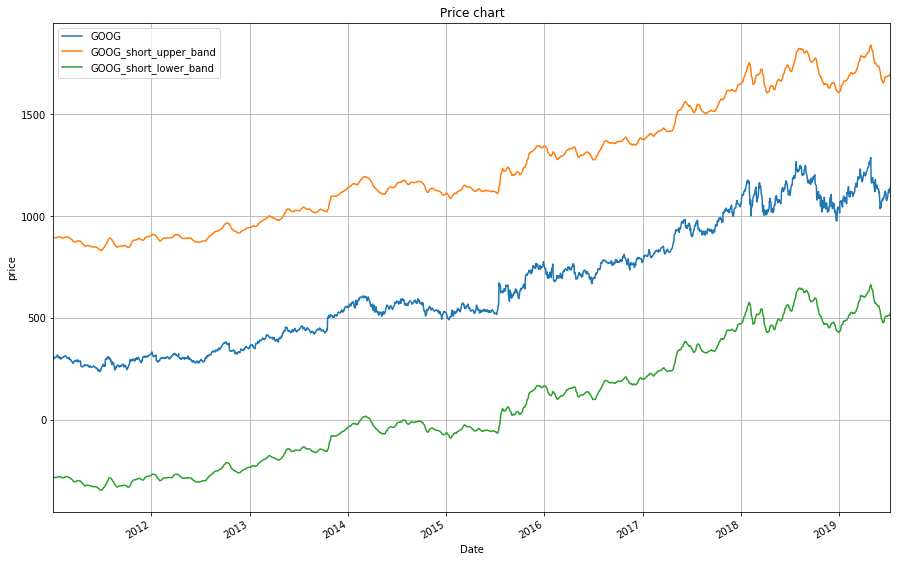

In [277]:
for ticker in tickers:
    if(ticker != ticker_of_interest):
        break
    else:
        ax = more_features[ticker].plot(title=ticker, label=ticker, figsize=(15,10))
        ax.legend()
        ax.grid()
        ax1 = more_features[ticker + '_short_upper_band'].plot(title=ticker+'_short_upper_band', label=ticker+'_short_upper_band', figsize=(15,10))
        ax1.legend()
        ax1.grid()
        ax2 = more_features[ticker + '_short_lower_band'].plot(title=ticker+'_short_lower_band', label=ticker+'_short_lower_band', figsize=(15,10))
        ax2.legend()
        ax2.grid()
    
plt.xlabel('Date')
plt.ylabel('price')
plt.title('Price chart')
plt.show()

In [280]:
all_features = more_features.drop([(ticker_of_interest + '_future_price')], axis=1)
all_mean = all_features.mean(axis = 0)
all_std = all_features.std(axis = 0)
all_features_normed = (all_features - all_mean) / all_std
all_target = more_features[ticker_of_interest + '_future_price']

n = all_features.shape[0]
small_features_size = int(n * 0.75)

training_features = all_features[:small_features_size]
training_mean = training_features.mean(axis = 0)
training_std = training_features.std(axis = 0)
training_features_normed = (training_features - training_mean) / training_std
training_target = all_target[:small_features_size]

n = training_features.shape[0]
small_features_size = int(n * 0.75)

small_features = all_features[:small_features_size]
small_mean = small_features.mean(axis = 0)
small_std = small_features.std(axis = 0)
small_features_normed = (small_features - small_mean) / small_std
small_target = all_features[:small_features_size]

features_validation = all_features[small_features_size:]
features_validation_normed = (features_validation - training_mean) / training_std
price_validation = more_features[ticker_of_interest][small_features_size:]
future_price_validation = more_features[ticker_of_interest + '_future_price'][small_features_size:]


In [281]:
def train_predict(models, X_train, y_train, X_test, y_test, price_validation):
    """
    The function loop through list of models and fit the training set
    then it prints the r2 score.
  
    Parameters: 
        models (list): The list of models.
        X_train: Features training set.
        y_train: Target training set.
        
        
    """
    for model in models:
        print("Train using: " , model.__class__.__name__)
        model.fit(X_train,y_train)
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)
        print("r2 score for train: ",r2_score(y_train,train_predict))
        
        print("r2 score for test: ",r2_score(y_test,test_predict))
        print(model)
        print()

In [282]:
models = []
models.append(LinearRegression())
models.append(DecisionTreeRegressor())
models.append(RandomForestRegressor())
models.append(SVR())
models.append(Lasso())
models.append(ElasticNet())
models.append(GradientBoostingRegressor())
models.append(AdaBoostRegressor())
models.append(KNeighborsRegressor())

train_predict(models, training_features_normed, training_target, features_validation_normed, future_price_validation, price_validation)


Train using:  LinearRegression
r2 score for train:  0.9922902816971146
r2 score for test:  0.9636190708337959
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Train using:  DecisionTreeRegressor
r2 score for train:  1.0
r2 score for test:  0.5553407931451997
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Train using:  RandomForestRegressor


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r2 score for train:  0.99955873422585
r2 score for test:  0.3904918124568453
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Train using:  SVR


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


r2 score for train:  0.853425567110007
r2 score for test:  -4.727367488293808
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

Train using:  Lasso
r2 score for train:  0.991508996909778
r2 score for test:  0.9692373539647497
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Train using:  ElasticNet
r2 score for train:  0.9863187525215464
r2 score for test:  0.931852129249808
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Train using:  GradientBoostingRegressor
r2 score for train:  0.9979477500037761
r2 score for test:  0.2043945965843469
GradientBoostingRegressor(alpha=0

In [283]:
def tune_parameters(model, parameters, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(model, parameters, scoring = 'r2', return_train_score=True, verbose=1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

    train_predict = grid_search.predict(X_train)
    test_predict = grid_search.predict(X_test)

    print("r2 score for train: ",r2_score(y_train,train_predict))
    print("r2 score for test: ",r2_score(y_test,test_predict))
    
    return grid_search

In [284]:
lr_model = LinearRegression()
parameters = {'fit_intercept': [True,False],
                'normalize': [True,False],
             }

#parameters = {'max_depth': [None],
#              'min_samples_leaf':[2], 
#              'n_estimators' : [400]
#             }


lr_tuned = tune_parameters(lr_model, parameters, training_features_normed, training_target, features_validation_normed, future_price_validation)



/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'fit_intercept': True, 'normalize': False}
r2 score for train:  0.9922902816971146
r2 score for test:  0.9636190708337959


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.2s finished


In [285]:
lso_model = Lasso(random_state = 50)
parameters = { 'alpha':[0.0001, 0.001, 0.02, 0.025, 0.03, 0.1, 0.4, 0.7, 0.9],
                'fit_intercept': [True,False],
                'normalize':[True,False], 
                'max_iter' : [1,5,20,100,200],
                'tol': [1,5,20,100,200],
                'warm_start': [True,False],
                'positive' :[True,False]
             }

#parameters = { 'alpha':[0],
#                'fit_intercept': [True],
#                'normalize':[True], 
#                'max_iter' : [1],
#                'tol': [1],
#                'warm_start': [True],
#                'positive' :[True]
#             }

lso_tuned = tune_parameters(lso_model, parameters, training_features_normed, training_target, features_validation_normed, future_price_validation)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
{'alpha': 0.025, 'fit_intercept': True, 'max_iter': 1, 'normalize': True, 'positive': True, 'tol': 1, 'warm_start': True}
r2 score for train:  0.991354050167292
r2 score for test:  0.9681300603208962


[Parallel(n_jobs=1)]: Done 10800 out of 10800 | elapsed:  1.8min finished


In [286]:
en_model = ElasticNet(random_state = 50)
#parameters = { 'alpha':[0.00001, 0.0001, 0.001, 0.02, 0.025, 0.03, 0.1, 0.4, 0.7, 0.9],
#                'l1_ratio' : [0.00001, 0.0001, 0.001, 0.02, 0.025, 0.03, 0.1, 0.4, 0.7, 0.9],
#                'fit_intercept': [True,False],
#                'normalize':[True,False], 
#                'max_iter' : [1,5,20,100,200],
#                'tol': [1,5,20,100,200],
#                'warm_start': [True,False],
#                'positive' :[True,False]
#             }

parameters = { 'alpha':[0.0001],
                'l1_ratio' : [0.4],
                'fit_intercept': [True],
                'normalize':[True], 
                'max_iter' : [1],
                'tol': [1],
                'warm_start': [True],
                'positive' :[True]
             }

en_tuned = tune_parameters(en_model, parameters, training_features_normed, training_target, features_validation_normed, future_price_validation)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'alpha': 0.0001, 'fit_intercept': True, 'l1_ratio': 0.4, 'max_iter': 1, 'normalize': True, 'positive': True, 'tol': 1, 'warm_start': True}
r2 score for train:  0.9912629524501423
r2 score for test:  0.9687737196143359


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [287]:
model = en_tuned.fit(all_features_normed,all_target)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [288]:
predictions = pd.DataFrame(columns=['Date', 'Predicted Price'])
current_date = datetime.datetime(2018,7,16)
next_day = current_date
for i in range(number_of_days_to_predict):
    print(i)
    print(next_day)
    try:
        value_to_predict = all_features_normed.loc[next_day].values
        value_to_predict = value_to_predict.reshape(1, -1)
        predict_current = model.predict(value_to_predict)
        future_date = next_day + BDay(number_of_days_to_predict)
        print(future_date)
        predictions.loc[i] = [future_date] + [predict_current[0]]
        next_day = next_day + BDay()
    except:
        print (sys.exc_info()[0])

0
2018-07-16 00:00:00
2018-07-23 00:00:00
1
2018-07-17 00:00:00
2018-07-24 00:00:00
2
2018-07-18 00:00:00
2018-07-25 00:00:00
3
2018-07-19 00:00:00
2018-07-26 00:00:00
4
2018-07-20 00:00:00
2018-07-27 00:00:00


In [289]:
predictions

,Date,Predicted Price
0,2018-07-23,1178.922566
1,2018-07-24,1192.838998
2,2018-07-25,1190.712570
3,2018-07-26,1182.377049
4,2018-07-27,1180.474157


Text(0, 0.5, 'Adjusted Close Price (USD)')

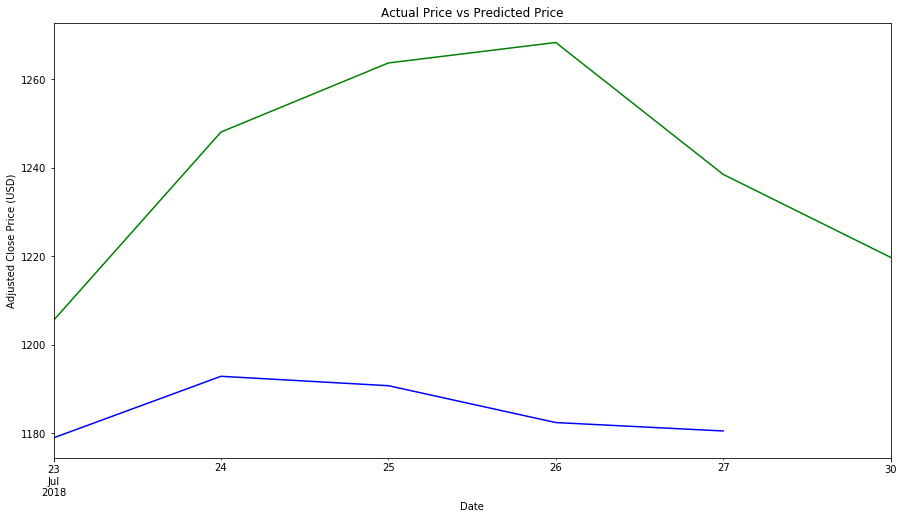

In [293]:
actual_price = all_features.loc[(current_date + BDay(number_of_days_to_predict)):(current_date + (2*BDay(number_of_days_to_predict)))][ticker_of_interest]
predict_price = predictions['Predicted Price']
actual_price_upper = actual_price*1.035
actual_price_lower = actual_price*0.965

predict_price_upper = predict_price*1.035
predict_price_lower = predict_price*0.965

predict_price.index = predictions['Date']
fig, ax = plt.subplots( nrows=1, ncols=1 )
fig.set_size_inches(15, 8)
actual_price.plot(ax = ax, title = "Actual Price vs Predicted Price", label="Actual Price", color="green")
predict_price.plot(ax = ax, label="Predicted Price", color="blue")

ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Close Price (USD)")

In [294]:
future_date = current_date + BDay(number_of_days_to_predict)
pct = []
for i in range(number_of_days_to_predict):
    actual_price = more_features.loc[future_date][ticker_of_interest]
    print(future_date)
    print('actual price' , actual_price)
    predict_price = predictions.loc[i]['Predicted Price']
    print('pred price' , predict_price)
    pct.append(((float(predict_price)-actual_price)/actual_price)*100)
    print(pct[i])
    future_date = future_date + BDay()
pct

2018-07-23 00:00:00
actual price 1205.5
pred price 1178.9225663192262
-2.204681350541167
2018-07-24 00:00:00
actual price 1248.0799560546875
pred price 1192.8389978816194
-4.426075261050627
2018-07-25 00:00:00
actual price 1263.699951171875
pred price 1190.7125696264502
-5.775689195662383
2018-07-26 00:00:00
actual price 1268.3299560546875
pred price 1182.3770488314026
-6.776856985279532
2018-07-27 00:00:00
actual price 1238.5
pred price 1180.474157390796
-4.685170981768582


[-2.204681350541167,
 -4.426075261050627,
 -5.775689195662383,
 -6.776856985279532,
 -4.685170981768582]

In [295]:
first_date = current_date + BDay(number_of_days_to_predict)
last_date = first_date + BDay(number_of_days_to_predict) - BDay(1)
actual_pct = (more_features.loc[last_date][ticker] - more_features.loc[first_date][ticker] ) / more_features.loc[first_date][ticker]
predict_pct = (predictions.iloc[-1]['Predicted Price'] - predictions.loc[0]['Predicted Price'] ) / predictions.loc[0]['Predicted Price']
print(actual_pct*100)
print(predict_pct*100)
print((actual_pct - predict_pct)*100)

0.4354079203101989
0.13161094001399726
0.30379698029620167
